In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
datos = pd.read_csv('data.csv')
magnitud = datos.iloc[:, 0]
funcionlum = datos.iloc[:, 1]
erromin = datos.iloc[:,2]
erromax = datos.iloc[:,3]

def	schechter(x,M,phi,alpha):
				m = 0.4*np.log(10)*phi*(10**(-0.4*(x-M)*(alpha+1)))*np.exp(-10**(-0.4*(x-M)))
				return m


def loglike(x, y, M, phi, alpha, sigma):
				m = schechter(x, M, phi, alpha)
				L = -(1/2) * np.sum(((y - m) / sigma) ** 2)
				return L


fiducial_M = -20.83
fiducial_phi = 1.46e-2
fiducial_alpha = -1.2

alphamin = fiducial_alpha*(1+0.1)
alphamax = fiducial_alpha*(1-0.1)
Mmin = fiducial_M*(1+0.1)
Mmax = fiducial_M*(1-0.1)
phimin = fiducial_phi*(1-0.2)
phimax = fiducial_phi*(1+0.2)


bordeinferr =	np.array([Mmin, phimin, alphamin])
bordesuperr = np.array([Mmax, phimax, alphamax])

def priors(params):
	if np.all(bordeinferr <= params) and np.all(params <= bordesuperr):
		return 0
	else:
		return -np.inf
	

def post(x, y, M, phi, alpha, sigma):
	params = np.array([M, phi, alpha])
	prior_prob = priors(params)
	return loglike(x, y, M, phi, alpha, sigma) + prior_prob


def normM(M):
    return (M - Mmin) / ( Mmax - Mmin)

def anti_normM(M):
				return (M * (Mmax - Mmin)) + Mmin

def normphi(phi):
				return (phi - phimin) / (phimax - phimin)

def anti_normphi(phi):
				return (phi * (phimax - phimin)) + phimin

def normalpha(alpha):
				return (alpha - alphamin) / (alphamax - alphamin)

def anti_normalpha(alpha):
				return (alpha * (alphamax - alphamin)) + alphamin


def mc(x, y, sigma, N):
	
	#Lanzamos en un lugar al azar dentro de los priors.
	M = np.random.uniform(Mmin, Mmax)
	phi = np.random.uniform(phimin, phimax)
	alpha = np.random.uniform(alphamin, alphamax)
	
	print('Initial values: ', M, phi, alpha)

	#Armamos las listas donde guardaremos todo
	Mreccorridos = np.zeros(N+1)
	phirecorridos = np.zeros(N+1)
	alpharecorridos = np.zeros(N+1)
	p = np.zeros(N+1)
	
	#Calculamos el primer valor de la probabilidad
	p[0] = post(x, y, M, phi, alpha, sigma)
	print(p[0])
	
	#Guardamos los primeros valores
	Mreccorridos[0] = M
	phirecorridos[0] = phi
	alpharecorridos[0] = alpha
	
	#Empezamos a recorrer
	for i in range(1,N+1):

		#Damos pasos inversamente proporcionales a la probabilidad, de modo que sean largos lejos del pico, y cortos cerca del pico.
		pp = 0.5

		M_paso = normM(M) + np.random.uniform(-1,1)*pp
		phi_paso = normphi(phi) + np.random.uniform(-1,1)*pp
		alpha_paso = normalpha(alpha) + np.random.uniform(-1,1)*pp
		
		#Ahora, desonormalizamos para calcular la probabilidad:
		M_paso = anti_normM(M_paso)
		phi_paso = anti_normphi(phi_paso)
		alpha_paso = anti_normalpha(alpha_paso)

		#Ahora, si la probabilidad del paso es mayor a la probabilidad actual, nos movemos a ese paso.
		current_post = post(x, y, M_paso, phi_paso, alpha_paso, sigma)
		dif = current_post - p[i-1]
		print(dif)
		ran = np.log(np.random.uniform(0,1))
		if  dif > ran:
			M = M_paso
			phi = phi_paso
			alpha = alpha_paso
		
		Mreccorridos[i] = M
		phirecorridos[i] = phi
		alpharecorridos[i] = alpha
		p[i] = post(x, y, M, phi, alpha, sigma)

	#Obtengo todos los valores de los parametros
	return	Mreccorridos, phirecorridos, alpharecorridos, p

In [28]:
sigma = (erromax-erromin)/2
mcad, phicad, alphacad, logpcad = mc(magnitud, funcionlum, sigma, 10000)

Initial values:  -20.77266618744371 0.011827507405952049 -1.1560571171725138
-72986.13307344366
-442650.7463547387
-inf
-inf
-inf
-inf
-169085.66473565376
-50274760.5042268
-91039687.34208883
45103.788834897394
-inf
-415964636.1695115
-inf
-inf
-281496.2583824878
-266857564.66876662
-inf
-inf
-inf
-inf
-inf
-inf
-491261.9653207438
-2636770.9882600205
-791836.4968938079
-inf
-inf
-496569.97664834553
-273054.98015832837
-inf
-60553.371125407706
-inf
-179214006.92232186
-inf
-4872725.351870822
-inf
-inf
-584868.3448320406
-inf
-inf
-63105124.80168945
-inf
-inf
-52290847.28896198
-727185.1241501572
-5604875.188253284
-268035.2680698033
-62212490.46282689
-56807855.47616943
-inf
-inf
-367693.49817750865
-inf
-143883664.3756018
-126335763.25784136
-inf
-65155692.90853321
-inf
-281425194.9101804
-526481.0308932619
-inf
-inf
-35010.00878157109
-616119.5388306176
-404552.0238578072
-inf
-inf
-393028.8091186257
-665473.7942600609
-638980.1569103508
-inf
-185004.75015611108
-inf
-475584.934264269

In [29]:
m_medio	= np.mean(mcad[-4000:])
phi_medio = np.mean(phicad[-4000:])
alpha_medio = np.mean(alphacad[-4000:])
print('M: ', m_medio)
print('phi: ', phi_medio)
print('alpha: ', alpha_medio)

M:  -20.777705294039055
phi:  0.016312010483419508
alpha:  -1.0929831306306386


In [30]:

curvainferior = (-21.5,1e-2,-1.7)
curvasuperior=	(-20, 1.9e-2,-0.96)

def priors_graf(params):
	if np.all(curvainferior <= params) and np.all(params <= curvasuperior):
		return 0
	else:
		return -np.inf
	
def post_graf(x, y, M, phi, alpha, sigma):
	params = np.array([M, phi, alpha])
	prior_prob = priors_graf(params)
	return loglike(x, y, M, phi, alpha, sigma) + prior_prob

m_nivel = np.linspace(curvainferior[0], curvasuperior[0], 50)
phi_nivel = np.linspace(curvainferior[1], curvasuperior[1], 50)
alpha_nivel = np.linspace(curvainferior[2], curvasuperior[2], 50)

alpha_fijo = (curvainferior[2]+curvasuperior[2])/2
phi_fijo = (curvainferior[1]+curvasuperior[1])/2
M_fijo = (curvainferior[0]+curvasuperior[0])/2


z = np.zeros((50, 50))
for i in range(50):
	for j in range(50):
				z[i, j] = post_graf(magnitud, funcionlum, m_nivel[i], phi_medio, alpha_nivel[j], sigma)

z_phi_alpha = np.zeros((50, 50))
for i in range(50):
	for j in range(50):
		z_phi_alpha[i, j] = post_graf(magnitud, funcionlum, m_medio, phi_nivel[i], alpha_nivel[j], sigma)

z_m_phi = np.zeros((50, 50))
for i in range(50):
	for j in range(50):
		z_m_phi[i, j] = post_graf(magnitud, funcionlum, m_nivel[i], phi_nivel[j], alpha_medio, sigma)

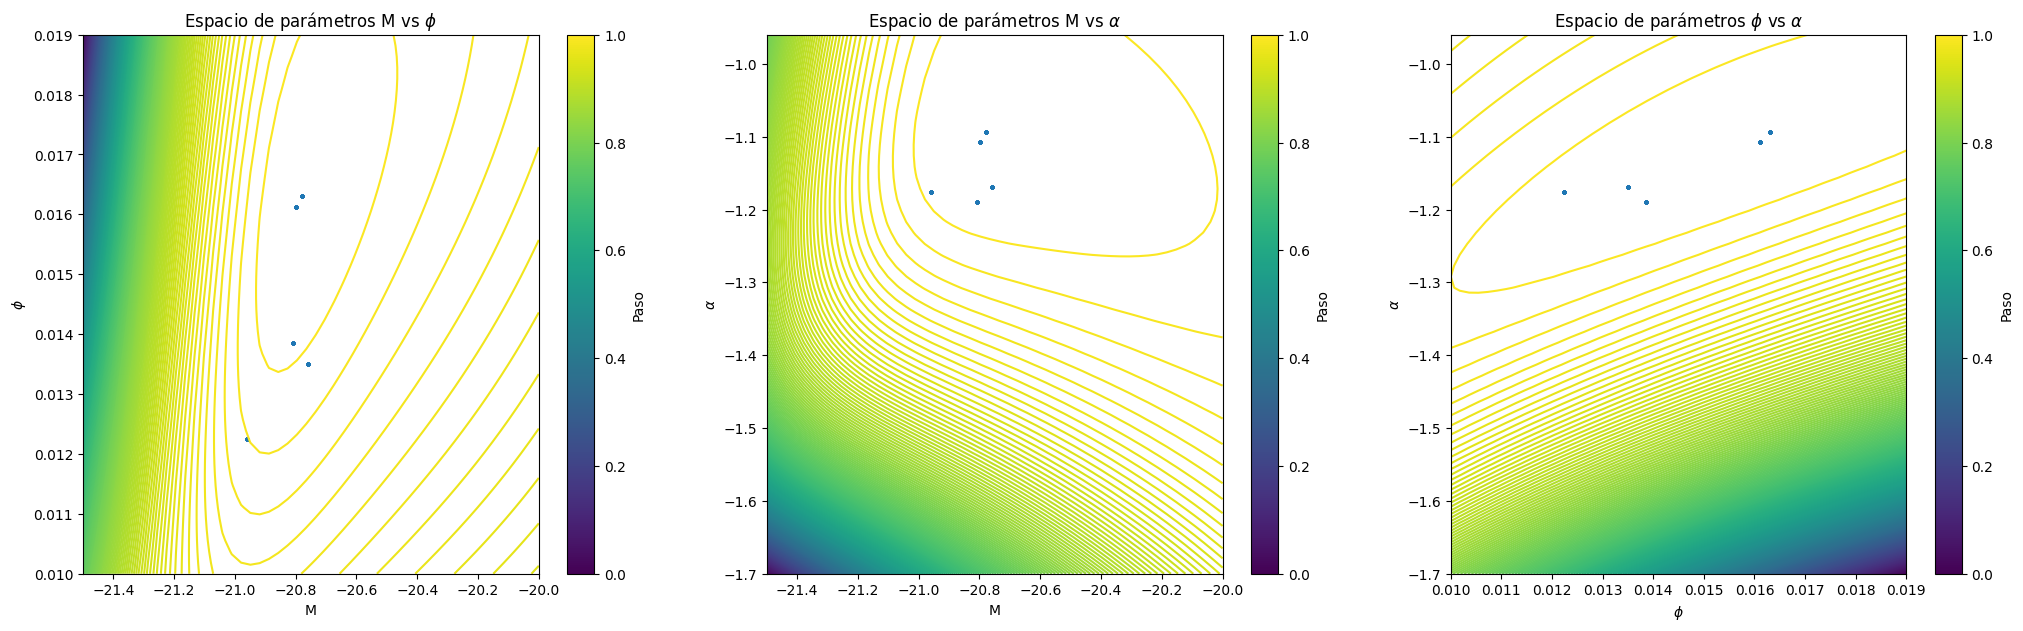

In [31]:
f, axs = plt.subplots(1, 3, figsize=(25, 7))

# Gráfico de M vs phi
sc0 = axs[0].scatter(mcad[10:], phicad[10:], marker='.', s=10)
cbar0 = plt.colorbar(sc0, ax=axs[0])
cbar0.set_label('Paso')
axs[0].set_xlabel('M')
axs[0].set_ylabel('$\phi$')
axs[0].set_title('Espacio de parámetros M vs $\phi$')
axs[0].contour(m_nivel, phi_nivel, z_m_phi.T, cmap='viridis', levels=256)

# Gráfico de M vs alpha
sc1 = axs[1].scatter(mcad[10:], alphacad[10:], marker='.', s=10)
cbar1 = plt.colorbar(sc1, ax=axs[1])
cbar1.set_label('Paso')
axs[1].set_xlabel('M')
axs[1].set_ylabel('$\\alpha$')
axs[1].set_title('Espacio de parámetros M vs $\\alpha$')
axs[1].contour(m_nivel, alpha_nivel, z.T, cmap='viridis', levels=256)
#axs[1].set_xlim(Mmin,	Mmax)
#axs[1].set_ylim(alphamin, alphamax)

# Gráfico de phi vs alpha
sc2 = axs[2].scatter(phicad[10:], alphacad[10:], marker='.', s=10)
cbar2 = plt.colorbar(sc2, ax=axs[2])
cbar2.set_label('Paso')
axs[2].set_xlabel('$\phi$')
axs[2].set_ylabel('$\\alpha$')
axs[2].set_title('Espacio de parámetros $\phi$ vs $\\alpha$')
axs[2].contour(phi_nivel, alpha_nivel, z_phi_alpha.T, cmap='viridis', levels=256)

plt.show()